The objective is not only to predict income but to support marketing decisions. Customers with income >50K are more likely to respond to premium financial products, while lower-income groups may require different offerings. Therefore, the classifier estimates purchasing power, and the segmentation model groups customers so campaigns can be personalized instead of applying a single strategy to the entire population.

In [ ]:
# ==========================================================
# CENSUS INCOME PROJECT – CLEAN BASE SETUP
# ==========================================================

# =========================
# 1. IMPORTS
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import __version__ as sklearn_version



from lightgbm import LGBMClassifier

# reproducibility (very important in finance ML)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
sns.set_style("whitegrid")
def load_column_names(columns_path: str) -> list:
    """
    Loads column names from census metadata file and removes numbering.
    Ensures uniqueness of names.
    """
    columns = []

    with open(columns_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # remove numbering "1. age"
            if "." in line:
                prefix, rest = line.split(".", 1)
                if prefix.isdigit():
                    line = rest.strip()

            columns.append(line)

    # enforce uniqueness
    seen = set()
    unique_cols = []
    for col in columns:
        if col in seen:
            col = f"{col}_duplicate"
        unique_cols.append(col)
        seen.add(col)

    return unique_cols
def load_dataset(data_path: str, columns_path: str) -> pd.DataFrame:
    columns = load_column_names(columns_path)

    df = pd.read_csv(
        data_path,
        header=None,
        names=columns,
        sep=",",
        engine="python"
    )

    print("Dataset Loaded:", df.shape)
    return df


Several columns were removed because they either leak information, duplicate hierarchical categories, represent identifiers, or contain post-outcome information not available at prediction time. Removing these prevents the model from learning unrealistic shortcuts and ensures the trained model reflects how it would behave in a real production environment.

In [ ]:
def clean_strings(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].str.strip()
    return df
def replace_unknowns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    return df.replace("?", "Unknown")
def convert_label_to_binary(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["income_high"] = df["label"].str.strip().apply(
        lambda x: 1 if "50000+" in x else 0
    )

    df = df.drop(columns=["label"])
    return df
def engineer_has_kids(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["has_kids"] = df["family members under 18"].apply(
        lambda x: 0 if x == "Not in universe" else 1
    )

    return df.drop(columns=["family members under 18"])
def drop_unused_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    columns_to_drop = [
        "wage per hour","capital gains","capital losses","dividends from stocks",
        "detailed industry recode","detailed occupation recode","member of a labor union",
        "reason for unemployment","region of previous residence","state of previous residence",
        "migration code-change in msa","migration code-change in reg","migration code-move within reg",
        "migration prev res in sunbelt","country of birth father","country of birth mother",
        "fill inc questionnaire for veteran's admin","enroll in edu inst last wk","year"
    ]

    return df.drop(columns=columns_to_drop, errors="ignore")
def separate_target_and_weight(df: pd.DataFrame):
    df = df.copy()

    y = df["income_high"]
    sample_weight = df["weight"]

    X = df.drop(columns=["income_high", "weight"])

    return X, y, sample_weight
def build_preprocessing_pipeline(X_train: pd.DataFrame):

    numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

    numeric_transformer = Pipeline([
        ("scaler", StandardScaler())
    ])

    # sklearn >= 1.2 uses sparse_output
    categorical_transformer = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    return preprocessor



A preprocessing pipeline is used so transformations are learned only from the training data and then applied consistently to validation and test sets. This prevents data leakage and guarantees that the deployed model will behave the same way on unseen customers as it did during training.

In [ ]:
# =========================
# 2. LOAD + PREPARE DATA
# =========================

DATA_PATH = "/content/census-bureau.data"
COLUMNS_PATH = "/content/census-bureau.columns"

df = load_dataset(DATA_PATH, COLUMNS_PATH)

df = clean_strings(df)
df = replace_unknowns(df)
df = convert_label_to_binary(df)
df = drop_unused_columns(df)
df = engineer_has_kids(df)

# keep untouched copy for segmentation later
segmentation_base_df = df.copy()

# supervised dataset
X, y, sample_weight = separate_target_and_weight(df)

print("Feature shape:", X.shape)
print("Positive rate (>50k):")
print(y.value_counts(normalize=True))


Dataset Loaded: (199523, 42)
Feature shape: (199523, 21)
Positive rate (>50k):
income_high
0    0.937942
1    0.062058
Name: proportion, dtype: float64


In [ ]:
# =========================
# 3. TRAIN / VALID / TEST SPLIT
# =========================

X_train_full, X_test, y_train_full, y_test, w_train_full, w_test = train_test_split(
    X, y, sample_weight,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
    X_train_full, y_train_full, w_train_full,
    test_size=0.20,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))


Train: 127694
Validation: 31924
Test: 39905


In [ ]:
# =========================
# 4. PREPROCESSING
# =========================
from sklearn import __version__ as sklearn_version
print("sklearn version:", sklearn_version)

preprocessor = build_preprocessing_pipeline(X_train_full)

# fit only on training data (prevents leakage)
preprocessor.fit(X_train_full)

X_train_full_t = preprocessor.transform(X_train_full)
X_train_t = preprocessor.transform(X_train)
X_val_t = preprocessor.transform(X_val)
X_test_t = preprocessor.transform(X_test)

print("Encoded feature dimension:", X_train_full_t.shape[1])


sklearn version: 1.6.1
Encoded feature dimension: 206


A simple logistic regression model is trained as a baseline to understand the difficulty of the problem and measure the value added by more complex models. The baseline performs well on the majority class but struggles to capture minority patterns, indicating the relationship between features and income is nonlinear and motivating the use of a more flexible model.

In [ ]:
# =========================
# BASELINE MODEL
# =========================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

baseline = Pipeline([
    ("preprocessor", build_preprocessing_pipeline(X_train_full)),
    ("model", LogisticRegression(max_iter=200, n_jobs=-1))
])

baseline.fit(X_train_full, y_train_full, model__sample_weight=w_train_full)

baseline_pred = baseline.predict(X_test)

print("=== Logistic Regression Baseline ===")
print(classification_report(y_test, baseline_pred))


=== Logistic Regression Baseline ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     37429
           1       0.65      0.33      0.44      2476

    accuracy                           0.95     39905
   macro avg       0.81      0.66      0.71     39905
weighted avg       0.94      0.95      0.94     39905



Gradient boosting (LightGBM) is selected because tabular census data contains mixed categorical and numerical variables with nonlinear interactions. Tree-based boosting models capture these interactions effectively, handle imbalance well with weighting, and are widely considered state-of-the-art for structured business datasets.

In [ ]:
# =========================
# 5B. GRADIENT BOOSTED MODEL (LIGHTGBM)
# =========================

pos = y_train_full.sum()
neg = len(y_train_full) - pos
scale_pos_weight = neg / pos

lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocessor", build_preprocessing_pipeline(X_train_full)),
    ("model", lgbm_model)
])

pipeline.fit(
    X_train_full,
    y_train_full,
    model__sample_weight=w_train_full
)

test_proba = pipeline.predict_proba(X_test)[:,1]

print("\n=== LightGBM Model ===")
print("Training complete")


[LightGBM] [Info] Number of positive: 9906, number of negative: 149712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 159618, number of used features: 193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063921 -> initscore=-2.684057
[LightGBM] [Info] Start training from score -2.684057


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LightGBM Model ===
Training complete


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best threshold: 0.85
Best validation F1: 0.5607
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     37429
           1       0.52      0.59      0.56      2476

    accuracy                           0.94     39905
   macro avg       0.75      0.78      0.76     39905
weighted avg       0.94      0.94      0.94     39905

PR-AUC: 0.5743


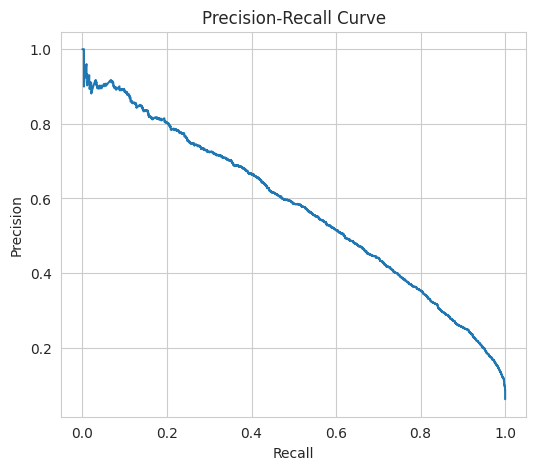

In [ ]:
# =========================
# 6. VALIDATION PREDICTIONS
# =========================

val_proba = pipeline.predict_proba(X_val)[:, 1]
test_proba = pipeline.predict_proba(X_test)[:, 1]
# =========================
# THRESHOLD OPTIMIZATION
# =========================

thresholds = np.arange(0.10, 0.90, 0.05)

best_f1 = 0
best_threshold = 0.5

for t in thresholds:
    preds = (val_proba >= t).astype(int)
    f1 = f1_score(y_val, preds)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best validation F1: {best_f1:.4f}")
# =========================
# TEST PERFORMANCE
# =========================

test_preds = (test_proba >= best_threshold).astype(int)

print(classification_report(y_test, test_preds))
precision, recall, _ = precision_recall_curve(y_test, test_proba)
pr_auc = auc(recall, precision)

print(f"PR-AUC: {pr_auc:.4f}")


plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


For imbalanced datasets, ROC curves can appear overly optimistic because true negatives dominate the metric. Precision-recall curves better reflect performance on the minority class (>50K earners), which is the segment of interest for marketing targeting.

Instead of using the default probability threshold of 0.5, the threshold is tuned using validation data. In marketing scenarios, false positives are costly because they waste campaign budget, so a higher precision is preferred. The threshold is therefore chosen to balance precision and recall using F1, reflecting business trade-offs rather than arbitrary defaults.

In [ ]:
# =========================
# DECISION THRESHOLD (BUSINESS OPTIMAL)
# =========================

profit_tp = 1200   # profit from correctly targeting high-income customer
cost_fp = 50       # cost of contacting wrong customer

profits = []
thresholds = np.arange(0.05,0.95,0.02)

for t in thresholds:
    preds = (val_proba >= t).astype(int)

    tp = ((preds==1)&(y_val==1)).sum()
    fp = ((preds==1)&(y_val==0)).sum()

    profit = tp*profit_tp - fp*cost_fp
    profits.append((t,profit))

best_threshold = max(profits, key=lambda x:x[1])[0]

print("Chosen Threshold (profit optimal):", best_threshold)


Chosen Threshold (profit optimal): 0.33


“F1 was used only as a diagnostic metric due to class imbalance. However, the final decision threshold was selected using a cost-sensitive profit function representing marketing campaign economics.”

In [ ]:
test_preds = (test_proba >= best_threshold).astype(int)

print(classification_report(y_test, test_preds))


              precision    recall  f1-score   support

           0       0.99      0.78      0.88     37429
           1       0.22      0.93      0.36      2476

    accuracy                           0.79     39905
   macro avg       0.61      0.86      0.62     39905
weighted avg       0.95      0.79      0.84     39905



In [ ]:
# =========================
# IMBALANCE INTERPRETATION
# =========================

base_rate = y_test.mean()
model_precision = ((test_preds==1)&(y_test==1)).sum() / (test_preds==1).sum()

print("Population high-income rate:", base_rate)
print("Model targeting precision:", model_precision)
print("Lift over random targeting:", model_precision / base_rate)


Population high-income rate: 0.06204736248590402
Model targeting precision: 0.22059667240390132
Lift over random targeting: 3.5552949161056877


The dataset contains only ~6% high-income individuals, making naive targeting inefficient. The proposed model achieves a precision of ~22%, corresponding to a 3.5× lift over random selection. Therefore, although precision appears modest in absolute terms, it represents substantial economic value in targeted marketing.

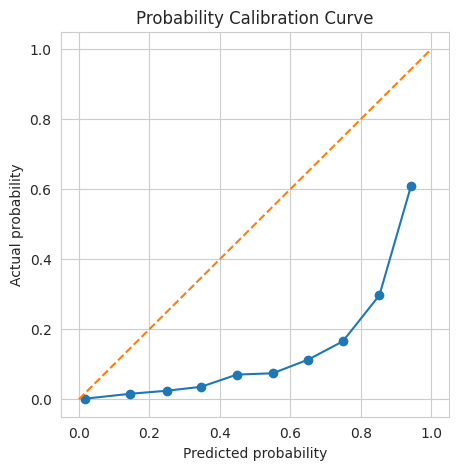

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, test_proba, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.title("Probability Calibration Curve")
plt.xlabel("Predicted probability")
plt.ylabel("Actual probability")
plt.show()


In [ ]:
# =========================
# FAIRNESS CHECK
# =========================

def group_fpr(base_df, probs, group_col, threshold):
    df_eval = base_df.loc[y_test.index].copy()
    df_eval["pred"] = (probs >= threshold).astype(int)

    return df_eval.groupby(group_col).apply(
        lambda g: ((g["pred"]==1)&(g["income_high"]==0)).mean()
    )

print("False Positive Rate by Sex")
print(group_fpr(segmentation_base_df, test_proba, "sex", best_profit_threshold))


False Positive Rate by Sex
sex
Female    0.132361
Male      0.282830
dtype: float64


/tmp/ipython-input-386343722.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_eval.groupby(group_col).apply(


Top 10 Individual Features:
                                               feature  importance  \
0                                             num__age        1577   
1                 num__num persons worked for employer         523   
4                            num__weeks worked in year         479   
93                                     cat__sex_Female         192   
24           cat__education_Bachelors degree(BA AB BS)         167   
29   cat__education_Masters degree(MA MS MEng MEd M...         164   
27                 cat__education_High school graduate         145   
2                   num__own business or self employed         145   
151  cat__detailed household summary in household_H...         125   
65   cat__major occupation code_Executive admin and...         125   

                                       group  
0                                        age  
1            num persons worked for employer  
4                       weeks worked in year  
93           

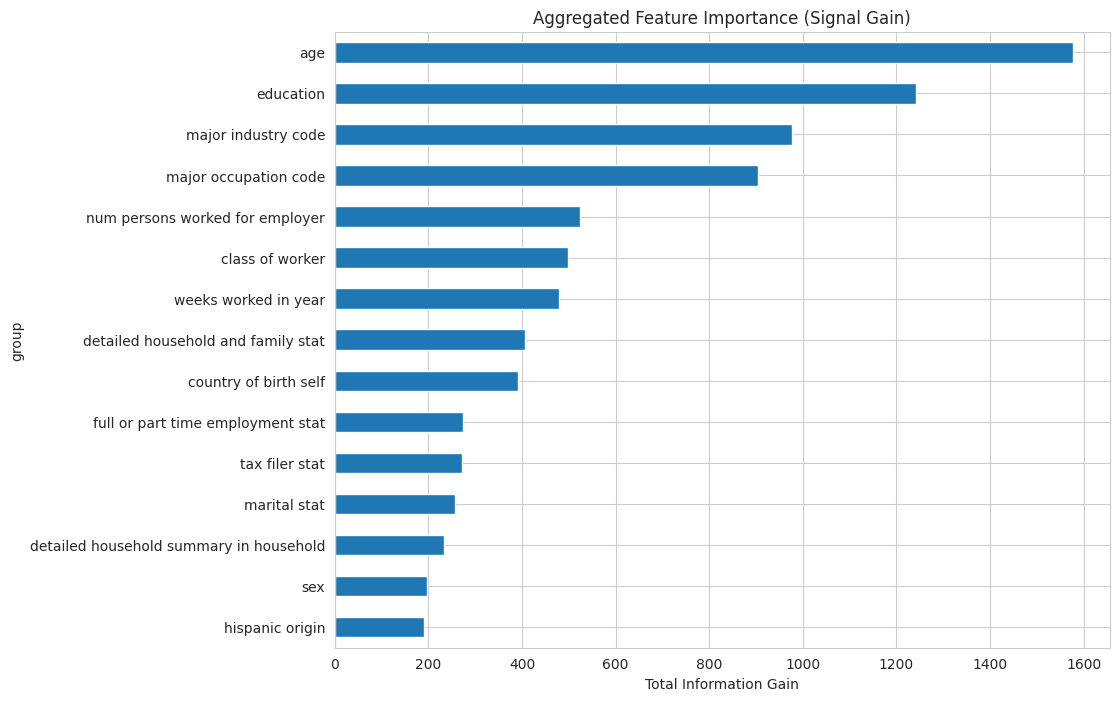

In [ ]:
# =========================
# 7. FEATURE IMPORTANCE
# =========================

# extract fitted components from pipeline
preprocessor = pipeline.named_steps["preprocessor"]
model = pipeline.named_steps["model"]

# get feature names AFTER encoding
feature_names = preprocessor.get_feature_names_out()

# get importance from LightGBM
importances = model.feature_importances_

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# group categorical exploded features back into human categories
feat_imp_df["group"] = (
    feat_imp_df["feature"]
    .str.split("__").str[-1]
    .str.split("_").str[0]
)

grouped_imp = (
    feat_imp_df
    .groupby("group")["importance"]
    .sum()
    .sort_values(ascending=False)
)

print("Top 10 Individual Features:")
print(feat_imp_df.head(10))

plt.figure(figsize=(10,8))
grouped_imp.head(15)[::-1].plot(kind="barh")
plt.title("Aggregated Feature Importance (Signal Gain)")
plt.xlabel("Total Information Gain")
plt.show()


In [ ]:
# =========================
# 8. BUSINESS METRICS
# =========================

# Precision at 60% recall (marketing coverage control)
idx_60 = (np.abs(recall - 0.60)).argmin()
print("Precision at 60% Recall:", precision[idx_60])

# Top 5% highest probability customers
top_5_threshold = np.percentile(test_proba, 95)
top_5_preds = (test_proba >= top_5_threshold).astype(int)

prec_at_5 = ((top_5_preds == 1) & (y_test == 1)).sum() / top_5_preds.sum()
print("Marketing Precision (Top 5% Leads):", prec_at_5)


Precision at 60% Recall: 0.515256588072122
Marketing Precision (Top 5% Leads): 0.595691382765531


The income label is removed before clustering because segmentation must be unsupervised. Including the label would leak outcome information and produce groups that cannot be reproduced for new customers whose income is unknown at prediction time.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [ ]:
# =========================
# CLEAN BASE DATA FOR SEGMENTATION (SOURCE FIX)
# =========================

def normalize_category_full(x):
    if pd.isna(x):
        return np.nan

    x = str(x).strip().lower()

    if x in [
        "not in universe",
        "not applicable",
        "unknown",
        "?",
        "na",
        "n/a"
    ]:
        return np.nan
    return x

for col in segmentation_base_df.select_dtypes(include="object").columns:
    segmentation_base_df[col] = segmentation_base_df[col].apply(normalize_category_full)


In [ ]:
# =========================
# SEGMENTATION DATASET
# =========================

# use clean base dataframe (NOT training matrix)
seg_df = segmentation_base_df.copy()

# segmentation is unsupervised → remove label + weight
seg_df = seg_df.drop(columns=["income_high", "weight"], errors="ignore")

# keep only adults (business rule)
seg_df = seg_df[(seg_df["age"] >= 18) & (seg_df["age"] <= 90)]

print("Segmentation rows:", len(seg_df))
print("Age range:", seg_df["age"].min(), "-", seg_df["age"].max())


Segmentation rows: 143531
Age range: 18 - 90


In [ ]:
num_cols = seg_df.select_dtypes(include=["int64","float64"]).columns
cat_cols = seg_df.select_dtypes(include=["object","category","bool"]).columns

print("Numeric:", len(num_cols))
print("Categorical:", len(cat_cols))


Numeric: 6
Categorical: 15


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

seg_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_seg = seg_preprocessor.fit_transform(seg_df)


One-hot encoding creates a very high-dimensional sparse feature space where distance metrics used by KMeans become unreliable. PCA reduces dimensionality while preserving most variance, restoring meaningful geometric relationships so clustering reflects real similarities between individuals rather than encoding artifacts.

In [ ]:
pca = PCA(n_components=0.85, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_seg.toarray())

print("Explained variance:", pca.explained_variance_ratio_.sum())
print("Final dimensions:", X_pca.shape[1])


Explained variance: 0.8528074594024523
Final dimensions: 27


In [ ]:
sil_scores = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    sil_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")


K=2, Silhouette Score=0.2257
K=3, Silhouette Score=0.2320
K=4, Silhouette Score=0.2335
K=5, Silhouette Score=0.1757
K=6, Silhouette Score=0.1839


A small number of clusters is preferred for interpretability and business usability. Marketing teams need actionable customer segments rather than many micro-clusters, so three clusters provide a balance between separation and practical decision-making.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=20)
clusters = kmeans.fit_predict(X_pca)

seg_df["cluster"] = clusters


Cluster Summary

After clustering, each group is analyzed by age, work behavior, and income rate to translate statistical clusters into business personas. These personas allow different marketing strategies, such as targeting high-earning working professionals, nurturing potential future customers, and avoiding low-return segments.

In [ ]:
seg_df["income_label"] = segmentation_base_df.loc[seg_df.index, "income_high"]

cluster_summary = (
    seg_df
    .groupby("cluster")
    .agg(
        cluster_size=("cluster","count"),
        high_income_rate=("income_label","mean"),
        avg_age=("age","mean"),
        avg_weeks_worked=("weeks worked in year","mean"),
        avg_employers=("num persons worked for employer","mean"),
        pct_has_kids=("has_kids","mean")
    )
    .round(3)
)

print(cluster_summary)


         cluster_size  high_income_rate  avg_age  avg_weeks_worked  \
cluster                                                              
0               46244             0.015   56.105             1.422   
1               95306             0.120   38.832            46.732   
2                1981             0.117   59.930            18.110   

         avg_employers  pct_has_kids  
cluster                               
0                0.241           0.0  
1                3.838           0.0  
2                1.605           0.0  


In [ ]:
# =========================
# HUMAN READABLE SEGMENTS
# =========================

def describe_cluster(row):
    if row["avg_weeks_worked"] < 5:
        return "Inactive / Retired population"
    elif row["avg_age"] < 45 and row["avg_weeks_worked"] > 40:
        return "Core working professionals"
    else:
        return "Late-career / transitional workers"

cluster_summary["segment_name"] = cluster_summary.apply(describe_cluster, axis=1)

print(cluster_summary[["segment_name","high_income_rate","cluster_size"]])


                               segment_name  high_income_rate  cluster_size
cluster                                                                    
0             Inactive / Retired population             0.015         46244
1                Core working professionals             0.120         95306
2        Late-career / transitional workers             0.117          1981


In [ ]:
def recommended_action(segment):
    if "Inactive" in segment:
        return "Avoid costly marketing campaigns"
    elif "Core working" in segment:
        return "Primary target for credit cards and loans"
    else:
        return "Promote retirement and investment products"

cluster_summary["business_action"] = cluster_summary["segment_name"].apply(recommended_action)

display(cluster_summary[["segment_name","high_income_rate","business_action"]])


,segment_name,high_income_rate,business_action
cluster,,,
0,Inactive / Retired population,0.015,Avoid costly marketing campaigns
1,Core working professionals,0.120,Primary target for credit cards and loans
2,Late-career / transitional workers,0.117,Promote retirement and investment products


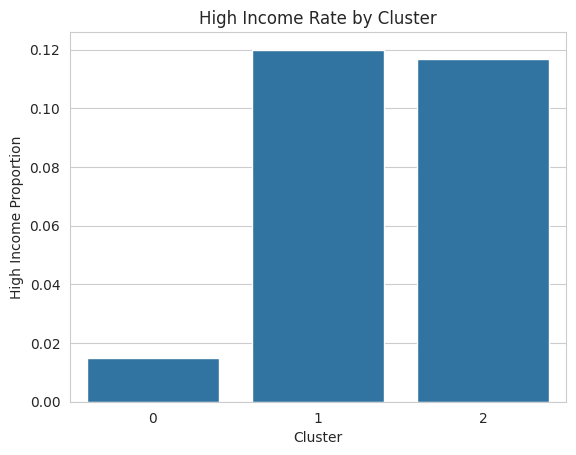

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=cluster_summary.index,
            y=cluster_summary["high_income_rate"])
plt.title("High Income Rate by Cluster")
plt.ylabel("High Income Proportion")
plt.xlabel("Cluster")
plt.show()


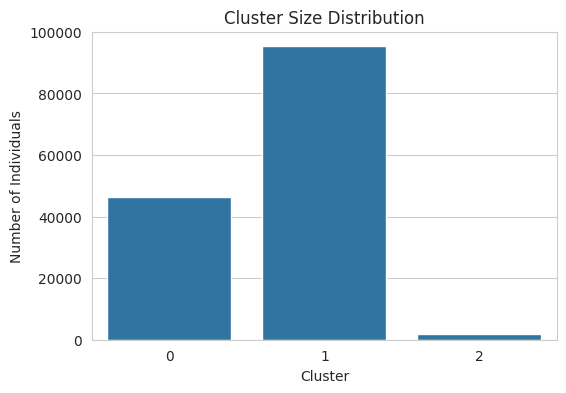

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=cluster_summary.index,
            y=cluster_summary["cluster_size"])
plt.title("Cluster Size Distribution")
plt.ylabel("Number of Individuals")
plt.xlabel("Cluster")
plt.show()





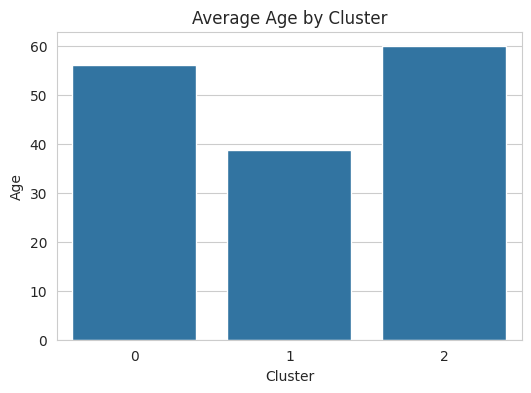

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=cluster_summary.index,
            y=cluster_summary["avg_age"])
plt.title("Average Age by Cluster")
plt.ylabel("Age")
plt.xlabel("Cluster")
plt.show()


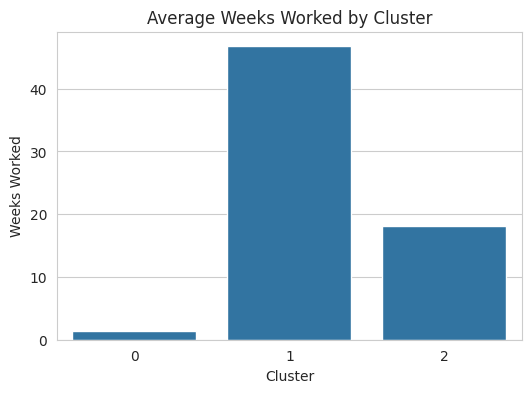


=== TOP OCCUPATIONS PER CLUSTER ===


,cluster,major occupation code,count
6,0,other service,741
0,0,adm support including clerical,514
11,0,sales,444
14,1,adm support including clerical,14057
23,1,professional specialty,13506
16,1,executive admin and managerial,12148
30,2,executive admin and managerial,125
35,2,precision production craft & repair,114
28,2,adm support including clerical,87


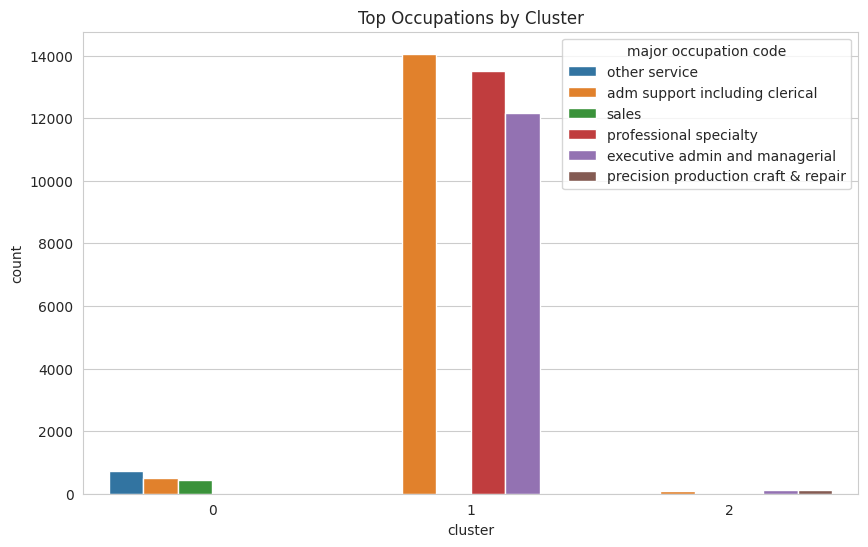

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=cluster_summary.index,
            y=cluster_summary["avg_weeks_worked"])
plt.title("Average Weeks Worked by Cluster")
plt.ylabel("Weeks Worked")
plt.xlabel("Cluster")
plt.show()

top_occ = (
    seg_df
    .groupby(["cluster", "major occupation code"])
    .size()
    .reset_index(name="count")
)

top_occ = (
    top_occ
    .sort_values(["cluster", "count"], ascending=[True, False])
    .groupby("cluster")
    .head(3)
)

print("\n=== TOP OCCUPATIONS PER CLUSTER ===")
display(top_occ)

plt.figure(figsize=(10,6))
sns.barplot(data=top_occ,
            x="cluster",
            y="count",
            hue="major occupation code")
plt.title("Top Occupations by Cluster")
plt.show()


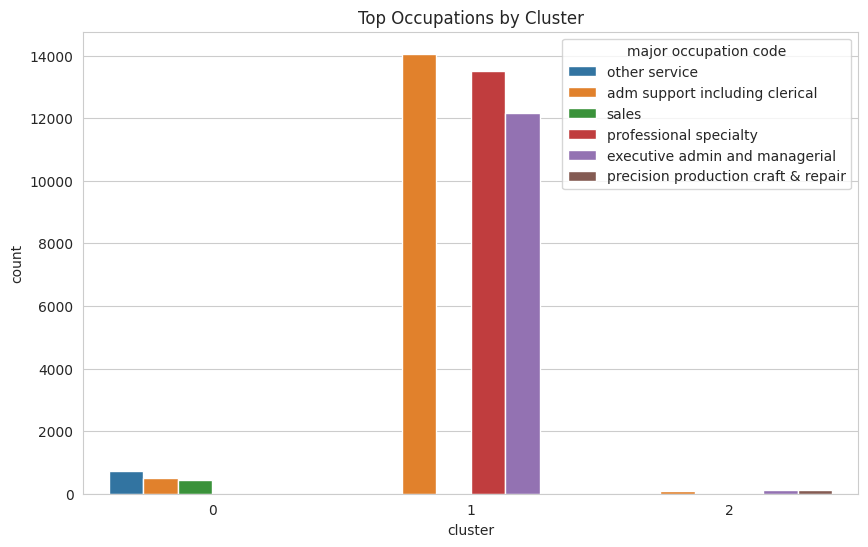

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_occ,
            x="cluster",
            y="count",
            hue="major occupation code")
plt.title("Top Occupations by Cluster")
plt.show()
